In [7]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [8]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Utilities as U, Parsers as P
import matplotlib.pyplot as plt
import numpy as np
import yaml, os

In [9]:
# Update data from the ismhpc server. The command has to be executed directly from the command line, 
# actually os.system does not recognize the files to be excluded. 
# The --dry-run option can be used to control the effects
# of the command before the real copy
dry_run = True
rsync_str = "rsync -rLptgoDzv --exclude={'*_fragment_*','*_fragments_*','*_CPU_*','*wfc*'} "
if dry_run: rsync_str += '--dry-run '
ssh_str = '-e ssh ismhpc:/work/dalessandro/OPTICAL_ORIENTATION/Echo_mechanisms_deacy_time/PHOTON_ECO/NSCF/ '
dest_path = 'NSCF'
dest_path = os.path.abspath(dest_path)
dest_path = "'%s'"%dest_path
command = rsync_str+ssh_str+dest_path
print(command)
#os.system(command)

rsync -rLptgoDzv --exclude={'*_fragment_*','*_fragments_*','*_CPU_*','*wfc*'} --dry-run -e ssh ismhpc:/work/dalessandro/OPTICAL_ORIENTATION/Echo_mechanisms_deacy_time/PHOTON_ECO/NSCF/ '/home/marco/Data/RICERCA/DFT AND MANY BODY/OPTICAL ORIENTATION/Echo mechanisms and decay time/PHOTON_ECO/NSCF'


In [10]:
omp = 1
mpi = 16

In [11]:
#code = C.QeCalculator(omp=omp,mpi=mpi) 
code = C.QeCalculator(omp=omp,mpi=mpi,scheduler='slurm',sbatch_options=['--partition=all12h'])
code.global_options()

Initialize a QuantumESPRESSO calculator with scheduler slurm


{'omp': 1,
 'mpi': 16,
 'mpi_run': 'mpirun -np',
 'executable': 'pw.x',
 'scheduler': 'slurm',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'sbatch_options': ['--partition=all12h'],
 'activate_BeeOND': True,
 'verbose': True}

# DFT analysis of GaAs

This notebook contains the analysis of the GaAs (__without__ SO interaction) performed with QuantumESPRESSO. In particular

* GS convergence for the energy cutoff, the number of kpoints and the equilibrium lattice constant
* Plot of the band structure along a path and determination of the value of the scissor nedded to set the gap to 1.42 eV, that correspond
   to the experimental value at 300 K.
* NSCF computations performed on various kpoints samplings, needed for the subsequent RT analysis.
* Analysis of the Dos
* Analysis of the JDos

## GS convergence analysis

In [4]:
run_dir = 'GS_convergence'

We define a basic input object for scf calculations

In [5]:
inp = I.PwInput()
inp.set_scf(force_symmorphic=True,conv_thr=1e-6)
inp.set_pseudo_dir(pseudo_dir='../pseudos')
inp.set_lattice(2,celldm1=10.6) #first guess to the celldm1 to be checked later
inp.set_occupations(occupations='fixed')
inp.add_atom('Ga','Ga_hamlu.fhi.UPF')
inp.add_atom('As','As_hamlu.fhi.UPF')
inp.set_atoms_number(2)
inp.set_atomic_positions([['Ga',[0.,0.,0.]],['As',[0.25,0.25,0.25]]],type='alat')
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'ibrav': 2,
  'celldm(1)': 10.6,
  'occupations': "'fixed'",
  'ntyp': '2',
  'nat': '2'},
 'electrons': {'conv_thr': 1e-06, 'diago_full_acc': '.false.'},
 'ions': {},
 'cell': {},
 'atomic_species': {'Ga': ['1.0', 'Ga_hamlu.fhi.UPF'],
  'As': ['1.0', 'As_hamlu.fhi.UPF']},
 'atomic_positions': {'type': 'alat',
  'values': [['Ga', [0.0, 0.0, 0.0]], ['As', [0.25, 0.25, 0.25]]]},
 'kpoints': {},
 'cell_parameters': {}}

### Convergence tests on the energy cutoff of the wavefunctions

We perform a first seek_convergence procedure using the cutoff energy of the wave functions as free parameter.
In this case we set the kpoints sampling on a grid 6,6,6

In [6]:
kvalue = 6
inp.set_kpoints(type='automatic',points=[kvalue,kvalue,kvalue])

We start with the value of 40 Ry

In [7]:
ecut = [10*i for i in range(4,10)]
ecut

[40, 50, 60, 70, 80, 90]

In [8]:
ecut_conv = D.Dataset(run_dir=run_dir)

In [10]:
for e in ecut:
    idd = {'ecut' : e, 'k' : kvalue}
    inp.set_prefix(D.name_from_id(idd))
    inp.set_energy_cutoff(e)
    ecut_conv.append_run(id=idd,input=inp,runner=code)

We use a postProcessing function to extract the total energy from the results and run a seek_convergence

In [11]:
ecut_conv.set_postprocessing_function(D.QE_get_energy)

In [12]:
ecut_conv.seek_convergence(rtol=1e-5)

Fetching results for id " {'ecut': 40, 'k': 6} "
Create the sub-directory 'GS_convergence'
run 0 command: mpirun -np 8 pw.x -inp ecut_40-k_6.in > ecut_40-k_6.log
slurm submit:  cd GS_convergence ; sbatch job_ecut_40-k_6.sh
run0_is_running: True 
Job completed
Fetching results for id " {'ecut': 50, 'k': 6} "
run 0 command: mpirun -np 8 pw.x -inp ecut_50-k_6.in > ecut_50-k_6.log
slurm submit:  cd GS_convergence ; sbatch job_ecut_50-k_6.sh
run0_is_running: True 
Job completed
Convergence reached in Dataset "Dataset" for id " {'ecut': 40, 'k': 6} "


({'ecut': 40, 'k': 6}, -12.35957277764044)

As a further convergence check on ecut_conv we compute the value of the direct gap.

First we perform the scf computations for the all the values of ecut since we need them as
source directory in the nscf calculations

In [13]:
code.update_global_options(multiTask=False)
ecut_conv.run()
code.update_global_options(multiTask=True)

Skip the run of ecut_40-k_6
Skip the run of ecut_50-k_6
run 2 command: mpirun -np 8 pw.x -inp ecut_60-k_6.in > ecut_60-k_6.log
run 3 command: mpirun -np 8 pw.x -inp ecut_70-k_6.in > ecut_70-k_6.log
run 4 command: mpirun -np 8 pw.x -inp ecut_80-k_6.in > ecut_80-k_6.log
run 5 command: mpirun -np 8 pw.x -inp ecut_90-k_6.in > ecut_90-k_6.log
slurm submit:  cd GS_convergence ; sbatch job_ecut_60-k_6.sh
run2_is_running: True 
Job completed
slurm submit:  cd GS_convergence ; sbatch job_ecut_70-k_6.sh
run3_is_running: True 
Job completed
slurm submit:  cd GS_convergence ; sbatch job_ecut_80-k_6.sh
run4_is_running: True 
Job completed
slurm submit:  cd GS_convergence ; sbatch job_ecut_90-k_6.sh
run5_is_running: True 
Job completed


Then we run the nscf computations at $\Gamma$ with the empty bands to compute the gap.

Since the various runs use different source_dir we need to use different calculators

In [14]:
gaps_data = D.Dataset(run_dir=run_dir)
num_bands = 6
klist = [[0.0,0.0,0.0,1.0]]

calcs = []
inp.set_nscf(num_bands,force_symmorphic=True,conv_thr=1e-6)
inp.set_kpoints(type='tpiba',klist=klist)
for ind,e in enumerate(ecut):
    source = 'GS_convergence/ecut_%s-k_%s.save'%(e,kvalue)
    calcs.append(C.QeCalculator(omp=omp,mpi=mpi,scheduler='slurm'))
    inp.set_energy_cutoff(e)
    idd = {'ecut': e, 'bands' : num_bands, 'sampling' : 'gamma'} 
    pref = D.name_from_id(idd)
    inp.set_prefix(pref)
    gaps_data.append_run(id=idd,input=inp,runner=calcs[ind],source_dir = source, multiTask=False)

Initialize a parallel QuantumESPRESSO calculator with scheduler slurm
Initialize a parallel QuantumESPRESSO calculator with scheduler slurm
Initialize a parallel QuantumESPRESSO calculator with scheduler slurm
Initialize a parallel QuantumESPRESSO calculator with scheduler slurm
Initialize a parallel QuantumESPRESSO calculator with scheduler slurm
Initialize a parallel QuantumESPRESSO calculator with scheduler slurm


In [15]:
gaps_data.set_postprocessing_function(D.QE_get_gap)

In [16]:
gaps_data.run()

Copy source_dir GS_convergence/ecut_40-k_6.save in the GS_convergence/bands_6-ecut_40-sampling_gamma.save
run 0 command: mpirun -np 8 pw.x -inp bands_6-ecut_40-sampling_gamma.in > bands_6-ecut_40-sampling_gamma.log
slurm submit:  cd GS_convergence ; sbatch job_bands_6-ecut_40-sampling_gamma.sh
run0_is_running: True 
Job completed
Copy source_dir GS_convergence/ecut_50-k_6.save in the GS_convergence/bands_6-ecut_50-sampling_gamma.save
run 0 command: mpirun -np 8 pw.x -inp bands_6-ecut_50-sampling_gamma.in > bands_6-ecut_50-sampling_gamma.log
slurm submit:  cd GS_convergence ; sbatch job_bands_6-ecut_50-sampling_gamma.sh
run0_is_running: True 
Job completed
Copy source_dir GS_convergence/ecut_60-k_6.save in the GS_convergence/bands_6-ecut_60-sampling_gamma.save
run 0 command: mpirun -np 8 pw.x -inp bands_6-ecut_60-sampling_gamma.in > bands_6-ecut_60-sampling_gamma.log
slurm submit:  cd GS_convergence ; sbatch job_bands_6-ecut_60-sampling_gamma.sh
run0_is_running: True 
Job completed
Copy

{0: 0.3760032799406727,
 1: 0.3762514503760502,
 2: 0.37583949169835584,
 3: 0.3755753159898999,
 4: 0.37569413720432004,
 5: 0.3758576764022796}

To be safe we choose

In [17]:
ecut_conv = 60

### Convergence tests on the number of kpoints for gs density

In [18]:
inp = I.PwInput()
inp.set_scf(force_symmorphic=True,conv_thr=1e-6)
inp.set_pseudo_dir(pseudo_dir='../pseudos')
inp.set_lattice(2,celldm1=10.6) #first guess to the celldm1 to be checked later
inp.set_occupations(occupations='fixed')
inp.add_atom('Ga','Ga_hamlu.fhi.UPF')
inp.add_atom('As','As_hamlu.fhi.UPF')
inp.set_atoms_number(2)
inp.set_energy_cutoff(ecut_conv)
inp.set_atomic_positions([['Ga',[0.,0.,0.]],['As',[0.25,0.25,0.25]]],type='alat')
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'ibrav': 2,
  'celldm(1)': 10.6,
  'occupations': "'fixed'",
  'ntyp': '2',
  'nat': '2',
  'ecutwfc': 60},
 'electrons': {'conv_thr': 1e-06, 'diago_full_acc': '.false.'},
 'ions': {},
 'cell': {},
 'atomic_species': {'Ga': ['1.0', 'Ga_hamlu.fhi.UPF'],
  'As': ['1.0', 'As_hamlu.fhi.UPF']},
 'atomic_positions': {'type': 'alat',
  'values': [['Ga', [0.0, 0.0, 0.0]], ['As', [0.25, 0.25, 0.25]]]},
 'kpoints': {},
 'cell_parameters': {}}

In [19]:
kvalue_conv = D.Dataset(run_dir=run_dir)

In [20]:
kvalues = [6,7,8]

In [21]:
for k in kvalues:
    idd = {'ecut' : ecut_conv, 'k' : k}
    inp.set_prefix(D.name_from_id(idd))
    inp.set_kpoints(points=[k,k,k])
    kvalue_conv.append_run(id=idd,input=inp,runner=code)

In [22]:
kvalue_conv.set_postprocessing_function(D.QE_get_energy)

In [23]:
kvalue_conv.seek_convergence(rtol=1e-4)

Fetching results for id " {'ecut': 60, 'k': 6} "
Skip the run of ecut_60-k_6
Job completed
Fetching results for id " {'ecut': 60, 'k': 7} "
run 0 command: mpirun -np 8 pw.x -inp ecut_60-k_7.in > ecut_60-k_7.log
slurm submit:  cd GS_convergence ; sbatch job_ecut_60-k_7.sh
run0_is_running: True 
Job completed
Convergence reached in Dataset "Dataset" for id " {'ecut': 60, 'k': 6} "


({'ecut': 60, 'k': 6}, -12.35965059691929)

We choose k = 6 that guarantees convergence at the order of 1meV

In [24]:
k_conv = 6

### Calculation of  the equilibrium lattice constants

In [25]:
inp = I.PwInput()
inp.set_scf(force_symmorphic=True,conv_thr=1e-6)
inp.set_pseudo_dir(pseudo_dir='../pseudos')
inp.set_lattice(2,celldm1=10.6) #first guess to the celldm1 to be checked later
inp.set_occupations(occupations='fixed')
inp.add_atom('Ga','Ga_hamlu.fhi.UPF')
inp.add_atom('As','As_hamlu.fhi.UPF')
inp.set_atoms_number(2)
inp.set_energy_cutoff(ecut_conv)
inp.set_kpoints(points=[k_conv,k_conv,k_conv])
inp.set_atomic_positions([['Ga',[0.,0.,0.]],['As',[0.25,0.25,0.25]]],type='alat')
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'ibrav': 2,
  'celldm(1)': 10.6,
  'occupations': "'fixed'",
  'ntyp': '2',
  'nat': '2',
  'ecutwfc': 60},
 'electrons': {'conv_thr': 1e-06, 'diago_full_acc': '.false.'},
 'ions': {},
 'cell': {},
 'atomic_species': {'Ga': ['1.0', 'Ga_hamlu.fhi.UPF'],
  'As': ['1.0', 'As_hamlu.fhi.UPF']},
 'atomic_positions': {'type': 'alat',
  'values': [['Ga', [0.0, 0.0, 0.0]], ['As', [0.25, 0.25, 0.25]]]},
 'kpoints': {'type': 'automatic', 'values': ([6, 6, 6], [0.0, 0.0, 0.0])},
 'cell_parameters': {}}

In [26]:
lat_conv = D.Dataset(run_dir=run_dir)

In [27]:
lat0 = 10.5
scale = 5e-3
deltas = [i for i in range(-3,4)]

In [28]:
inp.set_energy_cutoff(ecut_conv)
inp.set_kpoints(points=[k_conv,k_conv,k_conv])

In [29]:
for delta in deltas:
    idd = {'lat_delta' : delta}
    inp.set_prefix(D.name_from_id(idd))
    lat = lat0*(1+delta*scale)
    inp.set_lattice(2,celldm1=lat)
    lat_conv.append_run(id=idd,input=inp,runner=code,multiTask=False)

In [30]:
lat_conv.set_postprocessing_function(D.QE_get_energy)

In [31]:
results = lat_conv.run()

run 0 command: mpirun -np 8 pw.x -inp lat_delta_-3.in > lat_delta_-3.log
run 1 command: mpirun -np 8 pw.x -inp lat_delta_-2.in > lat_delta_-2.log
run 2 command: mpirun -np 8 pw.x -inp lat_delta_-1.in > lat_delta_-1.log
run 3 command: mpirun -np 8 pw.x -inp lat_delta_0.in > lat_delta_0.log
run 4 command: mpirun -np 8 pw.x -inp lat_delta_1.in > lat_delta_1.log
run 5 command: mpirun -np 8 pw.x -inp lat_delta_2.in > lat_delta_2.log
run 6 command: mpirun -np 8 pw.x -inp lat_delta_3.in > lat_delta_3.log
slurm submit:  cd GS_convergence ; sbatch job_lat_delta_-3.sh
run0_is_running: True 
Job completed
slurm submit:  cd GS_convergence ; sbatch job_lat_delta_-2.sh
run1_is_running: True 
Job completed
slurm submit:  cd GS_convergence ; sbatch job_lat_delta_-1.sh
run2_is_running: True 
Job completed
slurm submit:  cd GS_convergence ; sbatch job_lat_delta_0.sh
run3_is_running: True 
Job completed
slurm submit:  cd GS_convergence ; sbatch job_lat_delta_1.sh
run4_is_running: True 
Job completed
slur

We perform a quadratic fit of data

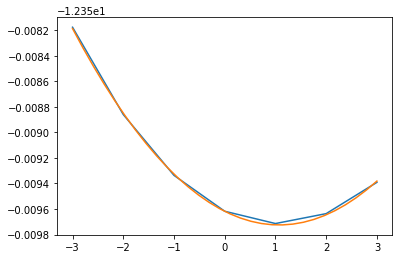

In [32]:
res = [results[i] for i in range(len(deltas))]
coeffs = np.polyfit(deltas,res,2)
values_fit = np.linspace(deltas[0],deltas[-1],30)
res_fit = [coeffs[0]*x**2+coeffs[1]*x+coeffs[2] for x in values_fit]
plt.plot(deltas,res)
plt.plot(values_fit,res_fit)

In [33]:
delta_eq = -coeffs[1]/(2*coeffs[0])
lat_eq = lat0*(1+delta_eq*scale)
lat_eq

10.556398783283278

This is the value of the equilibrium lattice constants. So to summarize

In [34]:
ecut_conv = 60
k_conv = 6
lat_eq = 10.556

We perform a last scf computation for the converged system, that will be used as starting point for the nscf ones

In [35]:
prefix = 'gs_converged'

inp = I.PwInput()
inp.set_scf(force_symmorphic=True,conv_thr=1e-6)
inp.set_prefix(prefix)
inp.set_pseudo_dir(pseudo_dir='../pseudos')
inp.set_lattice(2,celldm1=lat_eq) #first guess to the celldm1 to be checked later
inp.set_occupations(occupations='fixed')
inp.add_atom('Ga','Ga_hamlu.fhi.UPF')
inp.add_atom('As','As_hamlu.fhi.UPF')
inp.set_atoms_number(2)
inp.set_energy_cutoff(ecut_conv)
inp.set_kpoints(points=[k_conv,k_conv,k_conv])
inp.set_atomic_positions([['Ga',[0.,0.,0.]],['As',[0.25,0.25,0.25]]],type='alat')
inp

{'control': {'calculation': "'scf'",
  'verbosity': "'high'",
  'prefix': "'gs_converged'",
  'pseudo_dir': "'../pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'ibrav': 2,
  'celldm(1)': 10.556,
  'occupations': "'fixed'",
  'ntyp': '2',
  'nat': '2',
  'ecutwfc': 60},
 'electrons': {'conv_thr': 1e-06, 'diago_full_acc': '.false.'},
 'ions': {},
 'cell': {},
 'atomic_species': {'Ga': ['1.0', 'Ga_hamlu.fhi.UPF'],
  'As': ['1.0', 'As_hamlu.fhi.UPF']},
 'atomic_positions': {'type': 'alat',
  'values': [['Ga', [0.0, 0.0, 0.0]], ['As', [0.25, 0.25, 0.25]]]},
 'kpoints': {'type': 'automatic', 'values': ([6, 6, 6], [0.0, 0.0, 0.0])},
 'cell_parameters': {}}

In [36]:
code.run(run_dir=run_dir,inputs=[inp],names=[prefix])

run 0 command: mpirun -np 8 pw.x -inp gs_converged.in > gs_converged.log
slurm submit:  cd GS_convergence ; sbatch job_gs_converged.sh
run0_is_running: True 
Job completed


{'output': ['GS_convergence/gs_converged.save/data-file-schema.xml']}

# Analysis of the band structure

In [37]:
run_dir = 'QE_bands'

We compute the band structure along a path. We use the converged energy_cutoff and lattice parameters.

In [38]:
hsp = U.high_sym_fcc
klist = U.build_kpath(hsp['L'],hsp['G'],hsp['X'],hsp['K'],hsp['G'],numstep=30)
klist

[[0.5, 0.5, 0.5, 30],
 [0.0, 0.0, 0.0, 30],
 [0.0, 0.0, 1.0, 30],
 [0.0, 1.0, 1.0, 30],
 [0.0, 0.0, 0.0, 0]]

In [39]:
pref = 'bands' 

inp = I.PwInput()
inp.set_bands(8,force_symmorphic=True,conv_thr=1e-6)
inp.set_pseudo_dir(pseudo_dir='../pseudos')
inp.set_lattice(2,celldm1=lat_eq)
inp.set_occupations(occupations='fixed')
inp.add_atom('Ga','Ga_hamlu.fhi.UPF')
inp.add_atom('As','As_hamlu.fhi.UPF')
inp.set_atoms_number(2)
inp.set_atomic_positions([['Ga',[0.,0.,0.]],['As',[0.25,0.25,0.25]]],type='alat')
inp.set_energy_cutoff(ecut_conv)
inp.set_kpoints(type='tpiba_b',klist=klist)
inp.set_prefix(pref)
inp

{'control': {'calculation': "'bands'",
  'verbosity': "'high'",
  'pseudo_dir': "'../pseudos'",
  'prefix': "'bands'"},
 'system': {'nbnd': 8,
  'force_symmorphic': '.true.',
  'ibrav': 2,
  'celldm(1)': 10.556,
  'occupations': "'fixed'",
  'ntyp': '2',
  'nat': '2',
  'ecutwfc': 60},
 'electrons': {'conv_thr': 1e-06, 'diago_full_acc': '.false.'},
 'ions': {},
 'cell': {},
 'atomic_species': {'Ga': ['1.0', 'Ga_hamlu.fhi.UPF'],
  'As': ['1.0', 'As_hamlu.fhi.UPF']},
 'atomic_positions': {'type': 'alat',
  'values': [['Ga', [0.0, 0.0, 0.0]], ['As', [0.25, 0.25, 0.25]]]},
 'kpoints': {'type': 'tpiba_b',
  'values': [[0.5, 0.5, 0.5, 30],
   [0.0, 0.0, 0.0, 30],
   [0.0, 0.0, 1.0, 30],
   [0.0, 1.0, 1.0, 30],
   [0.0, 0.0, 0.0, 0]]},
 'cell_parameters': {}}

In [40]:
result = code.run(run_dir=run_dir,inputs=[inp],names=[pref],source_dir='GS_convergence/gs_converged.save')

Create the sub-directory 'QE_bands'
Copy source_dir GS_convergence/gs_converged.save in the QE_bands/bands.save
run 0 command: mpirun -np 8 pw.x -inp bands.in > bands.log
slurm submit:  cd QE_bands ; sbatch job_bands.sh
run0_is_running: True 
run0_is_running: True 
run0_is_running: True 
Job completed


In [41]:
bands = U.BandStructure.from_Pw(result['output'][0],hsp,set_gap=1.42)

Apply a scissor of 0.9546929186864358 eV


/home/dalessandro/Applications/MPPI/mppi/Utilities/BandStructure.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels,size=14)


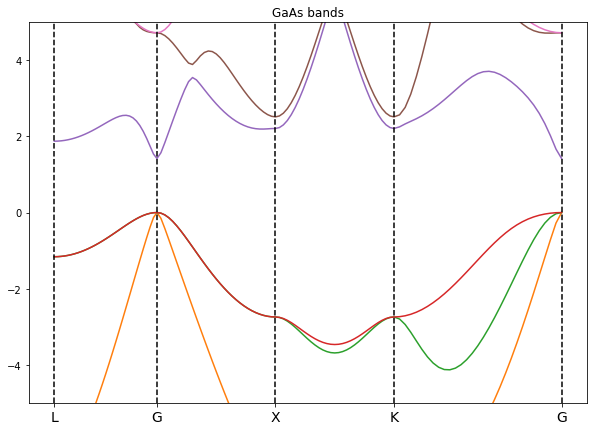

In [42]:
fig, ax = plt.subplots(figsize=(10, 7))
plt.title('GaAs bands')
plt.ylim(-5,5)
bands.plot(plt,selection=[i for i in range(0,7)])

It is useful also to display the band structure evidencing the region around $\Gamma$ that is sampled for the RT analysis

In [43]:
hs_positions = bands.get_high_sym_positions()
hs_positions

(['G', 'G', 'X', 'L', 'K'],
 [0.8660254037844385,
  4.28023896615753,
  1.8660254037844377,
  0.0,
  2.866025403784435])

In [44]:
kspan = 0.05 #in unit of 2pi/alat
k0 = hs_positions[1][0]
k0

0.8660254037844385

/home/dalessandro/Applications/MPPI/mppi/Utilities/BandStructure.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels,size=14)


(0.0, 1.864)

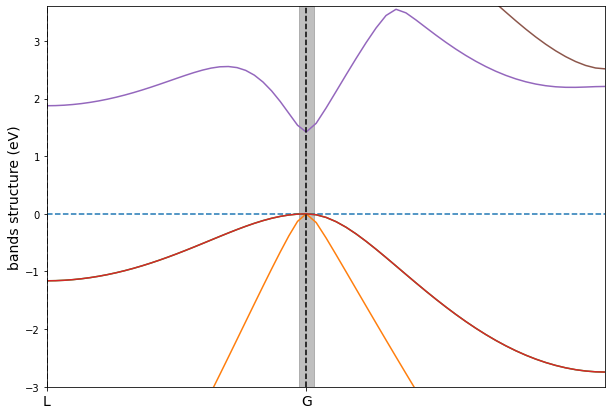

In [45]:
fig, ax = plt.subplots(figsize=(10, 7))
bands.plot(plt)
ax.axvspan(k0-kspan/2, k0+kspan/2, alpha=0.5, color='gray')
plt.ylim(-3,3.6)
plt.ylabel('bands structure (eV)',size=14)
plt.hlines(0.,0.,2,linestyles='--')
plt.xlim(0.,1.864)

## NSCF computation on various grids

We perform nscf computations on grids of various dimensions and type. These computations will be the starting points for various
RT analysis, to the effects of the kpoints sampling in the real-time reponse of the systems. 

All the computations share the same scf input. The common parameters are

In [12]:
run_dir = 'NSCF'

In [13]:
ecut_conv = 60
k_conv = 6
lat_eq = 10.556
source_dir = 'GS_convergence/gs_converged.save'
num_bands = 8

The basic input file is given by

In [14]:
inp = I.PwInput()
inp.set_nscf(num_bands,force_symmorphic=True,conv_thr=1e-6)
inp.set_pseudo_dir(pseudo_dir='pseudos')
inp.set_lattice(2,celldm1=lat_eq)
inp.set_occupations(occupations='fixed')
inp.add_atom('Ga','Ga_hamlu.fhi.UPF')
inp.add_atom('As','As_hamlu.fhi.UPF')
inp.set_atoms_number(2)
inp.set_atomic_positions([['Ga',[0.,0.,0.]],['As',[0.25,0.25,0.25]]],type='alat')
inp.set_energy_cutoff(ecut_conv)
inp

{'control': {'calculation': "'nscf'",
  'verbosity': "'high'",
  'prefix': "'pwscf'",
  'outdir': "'./'",
  'pseudo_dir': "'/home/marco/Data/RICERCA/DFT AND MANY BODY/OPTICAL ORIENTATION/Echo mechanisms and decay time/PHOTON_ECO/pseudos'"},
 'system': {'force_symmorphic': '.true.',
  'nbnd': 8,
  'ibrav': 2,
  'celldm(1)': 10.556,
  'occupations': "'fixed'",
  'ntyp': '2',
  'nat': '2',
  'ecutwfc': 60},
 'electrons': {'diago_full_acc': '.false.', 'conv_thr': 1e-06},
 'ions': {},
 'cell': {},
 'atomic_species': {'Ga': ['1.0', 'Ga_hamlu.fhi.UPF'],
  'As': ['1.0', 'As_hamlu.fhi.UPF']},
 'atomic_positions': {'type': 'alat',
  'values': [['Ga', [0.0, 0.0, 0.0]], ['As', [0.25, 0.25, 0.25]]]},
 'kpoints': {},
 'cell_parameters': {}}

### Regular grid

In [50]:
kpoints = 8 #20

In [51]:
idd = {'bnds' : num_bands, 'kpoints' : kpoints}
pref = D.name_from_id(idd)
inp.set_kpoints(type='automatic',points=[kpoints,kpoints,kpoints])
inp.set_prefix(pref)
#inp

In [52]:
result_reg = code.run(run_dir=run_dir,inputs=[inp],names=[pref],source_dir=source_dir)
result_reg

Copy source_dir GS_convergence/gs_converged.save in the NSCF/bnds_8-kpoints_8.save
run 0 command: mpirun -np 8 pw.x -inp bnds_8-kpoints_8.in > bnds_8-kpoints_8.log
slurm submit:  cd NSCF ; sbatch job_bnds_8-kpoints_8.sh
run0_is_running: True 
Job completed


{'output': ['NSCF/bnds_8-kpoints_8.save/data-file-schema.xml']}

### Gamma

In [53]:
klist = [[0.0,0.0,0.0,1.0]]

In [54]:
idd = {'bnds' : num_bands, 'sampling' : 'gamma'} 
pref = D.name_from_id(idd)
inp.set_kpoints(type='tpiba',klist=klist)
inp.set_prefix(pref)
inp

{'control': {'calculation': "'nscf'",
  'verbosity': "'high'",
  'pseudo_dir': "'../pseudos'",
  'prefix': "'bnds_8-sampling_gamma'"},
 'system': {'nbnd': 8,
  'force_symmorphic': '.true.',
  'ibrav': 2,
  'celldm(1)': 10.556,
  'occupations': "'fixed'",
  'ntyp': '2',
  'nat': '2',
  'ecutwfc': 60},
 'electrons': {'conv_thr': 1e-06, 'diago_full_acc': '.false.'},
 'ions': {},
 'cell': {},
 'atomic_species': {'Ga': ['1.0', 'Ga_hamlu.fhi.UPF'],
  'As': ['1.0', 'As_hamlu.fhi.UPF']},
 'atomic_positions': {'type': 'alat',
  'values': [['Ga', [0.0, 0.0, 0.0]], ['As', [0.25, 0.25, 0.25]]]},
 'kpoints': {'type': 'tpiba', 'values': [[0.0, 0.0, 0.0, 1.0]]},
 'cell_parameters': {}}

In [55]:
result_gamma = code.run(run_dir=run_dir,inputs=[inp],names=[pref],source_dir=source_dir)
result_gamma

Copy source_dir GS_convergence/gs_converged.save in the NSCF/bnds_8-sampling_gamma.save
run 0 command: mpirun -np 8 pw.x -inp bnds_8-sampling_gamma.in > bnds_8-sampling_gamma.log
slurm submit:  cd NSCF ; sbatch job_bnds_8-sampling_gamma.sh
run0_is_running: True 
Job completed


{'output': ['NSCF/bnds_8-sampling_gamma.save/data-file-schema.xml']}

In [56]:
data = P.PwParser(result_gamma['output'][0])

Parse file : NSCF/bnds_8-sampling_gamma.save/data-file-schema.xml


In [57]:
data.get_evals(set_gap=1.42)

Apply a scissor of 0.9546929035002345 eV


array([[-1.29871070e+01, -1.95060146e-09, -1.12857546e-09,
         0.00000000e+00,  1.42000000e+00,  4.72382720e+00,
         4.72382720e+00,  4.72382725e+00]])

### Random grid close to Gamma

In [15]:
import random as rand
num_kpoints = 1000
k_span = 0.1 #0.04
weight = [1.]

In [9]:
# generate the random list
klist = []
klist.append([0.,0.,0.]+weight) #we include Gamma
for n in range(num_kpoints-1):
    k_rand = [k_span*(rand.random()-0.5) for ind in range(3)] + weight
    klist.append(k_rand)

In [10]:
# write the list of kpoints to file
k_dict = {'kpoints': klist}
filename = os.path.join(run_dir,'klist_'+str(num_kpoints)+'-kspan_'+str(k_span)+'.yaml')
print('written to :',filename)
with open(filename, 'w') as yaml_file:    
    yaml.dump(k_dict, yaml_file, default_flow_style=True)

written to : NSCF/klist_1000-kspan_0.1.yaml


In [16]:
# read the list of kpoints from file
filename = os.path.join(run_dir,'klist_'+str(num_kpoints)+'-kspan_'+str(k_span)+'.yaml')
print('read from :',filename)
klist = yaml.safe_load(open(filename))['kpoints']
#klist

read from : NSCF/klist_1000-kspan_0.1.yaml


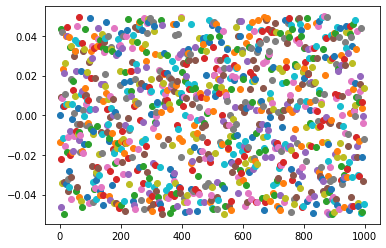

In [17]:
for ind,k in enumerate(klist):
    plt.scatter(ind,k[0])

In [18]:
idd = {'bnds' : num_bands, 'kpoints' : num_kpoints, 'sampling' : 'random_close_Gamma_kspan'+str(k_span)}  
pref = D.name_from_id(idd)
inp.set_kpoints(type='tpiba',klist=klist)
inp.set_prefix(pref)
#inp

In [19]:
result_random = code.run(run_dir=run_dir,input=inp,name=pref,source_dir=source_dir)
result_random

The folder /home/marco/Data/RICERCA/DFT AND MANY BODY/OPTICAL ORIENTATION/Echo mechanisms and decay time/PHOTON_ECO/NSCF/bnds_8-kpoints_1000-sampling_random_close_Gamma_kspan0.1.save already exists. Source_dir GS_convergence/gs_converged.save not copied
Skip the run of the input file bnds_8-kpoints_1000-sampling_random_close_Gamma_kspan0.1.in


'/home/marco/Data/RICERCA/DFT AND MANY BODY/OPTICAL ORIENTATION/Echo mechanisms and decay time/PHOTON_ECO/NSCF/bnds_8-kpoints_1000-sampling_random_close_Gamma_kspan0.1.save/data-file-schema.xml'

In [20]:
data = P.PwParser(result_random)

Parse file : /home/marco/Data/RICERCA/DFT AND MANY BODY/OPTICAL ORIENTATION/Echo mechanisms and decay time/PHOTON_ECO/NSCF/bnds_8-kpoints_1000-sampling_random_close_Gamma_kspan0.1.save/data-file-schema.xml


We compute the energy spread of the transitions

In [21]:
trans_vtoc1 = data.get_transitions(initial=[1,2,3],final=[4],set_gap=1.42)
trans_vtoc2 = data.get_transitions(initial=[1,2,3],final=[5],set_gap=1.42)
trans_c1toc2 = data.get_transitions(initial=[4],final=[5],set_gap=1.42)

In [22]:
from mppi.Utilities import Dos

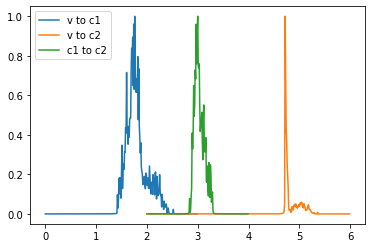

In [24]:
dos = Dos()
dos.append(trans_vtoc1.flatten(),minVal=0,maxVal=3,eta=1e-3,label='v to c1')
dos.append(trans_vtoc2.flatten(),minVal=2,maxVal=6,eta=1e-3,label='v to c2')
dos.append(trans_c1toc2.flatten(),minVal=2,maxVal=4,eta=1e-3,label='c1 to c2')
dos.plot(plt,rescale=True)

We find the position of the point with the energy more close to the value of 1.5 eV, that is the pump energy used in the RT simualations.

In [30]:
evals = data.get_evals(set_gap=1.42)

Parse file : /work/dalessandro/OPTICAL_ORIENTATION/Echo_mechanisms_deacy_time/PHOTON_ECO/NSCF/bnds_8-kpoints_1000-sampling_random_close_Gamma_kspan0.04.save/data-file-schema.xml
Apply a scissor of 0.9546929212546953 eV


In [14]:
pump_energy = 1.5
resonant_point = -1
delta_res = 10  
for ind,e in enumerate(evals):
    gap = e[4]-e[3]
    delta = pump_energy - gap
    if abs(delta) < abs(delta_res):
        delta_res = delta
        resonant_point = ind
gap_resonant = evals[resonant_point][4]-evals[resonant_point][3]
print('gap resonant point',gap_resonant)
print('resonant energy shift',pump_energy-gap_resonant)
print('resonant k position',resonant_point)
print('resonant k coordinate',klist[resonant_point])

gap resonant point 1.4999679849537104
resonant energy shift 3.201504628957963e-05
resonant k position 50
resonant k coordinate [0.012222375762903016, 0.008813912358998723, 0.0169281134202883, 1.0]


In [65]:
evals[resonant_point]

array([-1.29851541e+01, -8.54192767e-02, -4.97293187e-03, -2.28997190e-03,
        1.49766830e+00,  4.72301040e+00,  4.72858283e+00,  4.73120126e+00])

We also choose another point with a non vanishing gap to perform further comparisons between RT results
and the TLS model

In [54]:
k_chosen = 10
gap = evals[k_chosen][4]-evals[k_chosen][3]
delta = pump_energy-gap
print('delta',delta)
klist[k_chosen]

delta 0.031100977246261152


[-0.004968954438749265, -0.01312680000969086, 0.009982472062397859, 1.0]

check for the degeneracies in the valence sector

In [57]:
print(evals[k_chosen][3]-evals[k_chosen][2])
print(evals[k_chosen][3]-evals[k_chosen][1])
print(evals[k_chosen][3]-evals[k_chosen][0])

0.0023411457768967026
0.05094341088684029
12.984938404924776


__Selection of the kpoints in the energy range of the pulse__

In [32]:
data = P.PwParser('NSCF/bnds_8-kpoints_1000-sampling_random_close_Gamma_kspan0.04.save/data-file-schema.xml')

Parse file : NSCF/bnds_8-kpoints_1000-sampling_random_close_Gamma_kspan0.04.save/data-file-schema.xml


In [71]:
weights = data.weights
evals = data.get_evals(set_gap=1.42)
kpoints = data.kpoints
transitions = data.get_transitions(initial=[0,1,2,3],final=[4],set_gap=1.42)

Apply a scissor of 0.9546929212546953 eV


We extract among the 1000 kpoints in the volume of 0.04^3 around $\Gamma$ the ones for which some transitions
energy is in the energy range of the pulse

In [89]:
pulse_energy = 1.46
pulse_width = 0.025 # eV it gives the range of the abs of the maximum acceptable detuning. So the acceptance range is twice this value

In [90]:
ind_activated = []
for ind in range(len(transitions)):
    spread = np.abs(transitions[ind] - pulse_energy)
    if any(spread < pulse_width) :
        ind_activated.append(ind)
len(ind_activated)

509

In [95]:
weights_activated = weights[ind_activated]
trans_activated = transitions[ind_activated]
kpoints_activated = kpoints[ind_activated]

In [92]:
jdos = U.Dos()
jdos.append_fromPwData(transitions,weights,minVal=1,maxVal=2,eta=4e-3,label='all')
jdos.append_fromPwData(trans_activated,weights_activated,minVal=1,maxVal=2,eta=4e-3,label='activated')

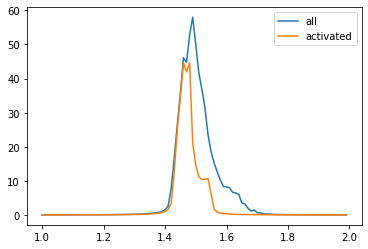

In [93]:
jdos.plot(plt)

In [97]:
kpoints_activated[0:10]

array([[ 1.357517e-02,  7.181320e-03, -8.099400e-04],
       [ 1.112759e-02,  1.374640e-03,  5.344830e-03],
       [-7.347470e-03,  6.100910e-03,  7.902810e-03],
       [-1.335025e-02,  1.094764e-02, -6.847820e-03],
       [ 8.419830e-03, -1.523404e-02,  5.112700e-03],
       [-1.560675e-02,  1.769560e-03, -4.285370e-03],
       [ 1.026519e-02,  9.339260e-03,  1.929870e-03],
       [-7.978870e-03,  1.715061e-02, -1.990290e-03],
       [ 7.970070e-03, -1.193058e-02,  7.490370e-03],
       [-5.726010e-03,  3.365920e-03,  1.207000e-05]])

In [109]:
kpoints_activated[0]

array([ 0.01357517,  0.00718132, -0.00080994])

In [113]:
weight = [1.]
klist_activated = []
for k in kpoints_activated:
    klist_activated.append(k.tolist()+weight)

In [125]:
idd = {'bnds' : num_bands, 'kpoints' : len(klist_activated), 'sampling' : 'activated-energy_'+str(pulse_energy)+'-width_'+str(pulse_width)}  
pref = D.name_from_id(idd)
inp.set_kpoints(type='tpiba',klist=klist_activated)
inp.set_prefix(pref)
#inp

In [127]:
result_activated = code.run(run_dir=run_dir,input=inp,name=pref,source_dir=source_dir)
result_activated

copy source_dir GS_convergence/gs_converged.save in the /work/dalessandro/OPTICAL_ORIENTATION/Echo_mechanisms_deacy_time/PHOTON_ECO/NSCF/bnds_8-kpoints_509-sampling_activated-energy_1.46-width_0.025.save
run command: mpirun -np 16 pw.x -inp bnds_8-kpoints_509-sampling_activated-energy_1.46-width_0.025.in > bnds_8-kpoints_509-sampling_activated-energy_1.46-width_0.025.log
slurm submit:  cd NSCF ; sbatch job_bnds_8-kpoints_509-sampling_activated-energy_1.46-width_0.025.sh
computation bnds_8-kpoints_509-sampling_activated-energy_1.46-width_0.025 is running...
computation bnds_8-kpoints_509-sampling_activated-energy_1.46-width_0.025 ended


'/work/dalessandro/OPTICAL_ORIENTATION/Echo_mechanisms_deacy_time/PHOTON_ECO/NSCF/bnds_8-kpoints_509-sampling_activated-energy_1.46-width_0.025.save/data-file-schema.xml'

### Point resonant with pump of 1.5 eV

In [8]:
klist = [[0.012222375762903016, 0.008813912358998723, 0.0169281134202883, 1.0]]

In [9]:
idd = {'bnds' : num_bands, 'sampling' : 'resonant_1.5eV'} 
pref = D.name_from_id(idd)
inp.set_kpoints(type='tpiba',klist=klist)
inp.set_prefix(pref)
inp

{'control': {'calculation': "'nscf'",
  'verbosity': "'high'",
  'pseudo_dir': "'../pseudos'",
  'prefix': "'bnds_8-sampling_resonant_1.5eV'"},
 'system': {'nbnd': 8,
  'force_symmorphic': '.true.',
  'ibrav': 2,
  'celldm(1)': 10.556,
  'occupations': "'fixed'",
  'ntyp': '2',
  'nat': '2',
  'ecutwfc': 60},
 'electrons': {'conv_thr': 1e-06, 'diago_full_acc': '.false.'},
 'ions': {},
 'cell': {},
 'atomic_species': {'Ga': ['1.0', 'Ga_hamlu.fhi.UPF'],
  'As': ['1.0', 'As_hamlu.fhi.UPF']},
 'atomic_positions': {'type': 'alat',
  'values': [['Ga', [0.0, 0.0, 0.0]], ['As', [0.25, 0.25, 0.25]]]},
 'kpoints': {'type': 'tpiba',
  'values': [[0.012222375762903016,
    0.008813912358998723,
    0.0169281134202883,
    1.0]]},
 'cell_parameters': {}}

In [10]:
result = code.run(run_dir=run_dir,inputs=[inp],names=[pref],source_dir=source_dir)
result

The folder NSCF/bnds_8-sampling_resonant_1.5eV.save already exsists. Source folder GS_convergence/gs_converged.save not copied
Skip the run of bnds_8-sampling_resonant_1.5eV
Job completed


{'output': ['NSCF/bnds_8-sampling_resonant_1.5eV.save/data-file-schema.xml']}

### Point with $\delta=31.1$ meV with pump of 1.5 eV

In [41]:
klist = [[-0.004968954438749265, -0.01312680000969086, 0.009982472062397859, 1.0]]

In [42]:
idd = {'bnds' : num_bands, 'sampling' : 'delta_31meV'} 
pref = D.name_from_id(idd)
inp.set_kpoints(type='tpiba',klist=klist)
inp.set_prefix(pref)
inp

{'control': {'calculation': "'nscf'",
  'verbosity': "'high'",
  'pseudo_dir': "'../pseudos'",
  'prefix': "'bnds_8-sampling_delta_31meV'"},
 'system': {'nbnd': 8,
  'force_symmorphic': '.true.',
  'ibrav': 2,
  'celldm(1)': 10.556,
  'occupations': "'fixed'",
  'ntyp': '2',
  'nat': '2',
  'ecutwfc': 60},
 'electrons': {'conv_thr': 1e-06, 'diago_full_acc': '.false.'},
 'ions': {},
 'cell': {},
 'atomic_species': {'Ga': ['1.0', 'Ga_hamlu.fhi.UPF'],
  'As': ['1.0', 'As_hamlu.fhi.UPF']},
 'atomic_positions': {'type': 'alat',
  'values': [['Ga', [0.0, 0.0, 0.0]], ['As', [0.25, 0.25, 0.25]]]},
 'kpoints': {'type': 'tpiba',
  'values': [[-0.004968954438749265,
    -0.01312680000969086,
    0.009982472062397859,
    1.0]]},
 'cell_parameters': {}}

In [45]:
result = code.run(run_dir=run_dir,inputs=[inp],names=[pref],source_dir=source_dir)
result

The folder NSCF/bnds_8-sampling_delta_31meV.save already exsists. Source folder GS_convergence/gs_converged.save not copied
Skip the run of bnds_8-sampling_delta_31meV
Job completed


{'output': ['NSCF/bnds_8-sampling_delta_31meV.save/data-file-schema.xml']}

In [47]:
pump_energy = 1.5
data = P.PwParser(result['output'][0])
evals = data.get_evals(set_scissor=0.9547660227121764)
gap = evals[0][4]-evals[0][3]
delta = pump_energy-gap
print('delta',delta)

Parse file : NSCF/bnds_8-sampling_delta_31meV.save/data-file-schema.xml
Apply a scissor of 0.9547660227121764 eV
delta 0.03110097376582477


## Analysis of the Dos

We can compare the Dos associated to the regular grid sampling with the one related to the random samplings.

In [85]:
dos = U.Dos.from_Pw('NSCF/bnds_8-kpoints_8.save/data-file-schema.xml',set_gap=1.42,eta=0.05,label='reg',minVal=-4,maxVal=4)

Apply a scissor of 0.9546929263113056 eV


In [86]:
dos.append_fromPw('NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.05.save/data-file-schema.xml',label='rand100_kspan0.05',set_gap=1.42,eta=0.01,minVal=-4.0,maxVal=4.0)
dos.append_fromPw('NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.03.save/data-file-schema.xml',label='rand100_kspan0.03',set_gap=1.42,eta=0.01,minVal=-4.0,maxVal=4.0)
dos.append_fromPw('NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.04.save/data-file-schema.xml',label='rand100_kspan0.04',set_gap=1.42,eta=0.01,minVal=-4.0,maxVal=4.0)

Apply a scissor of 0.9546929035002345 eV
Apply a scissor of 0.9546929035002345 eV
Apply a scissor of 0.9546929035002345 eV


We can compare all the dos

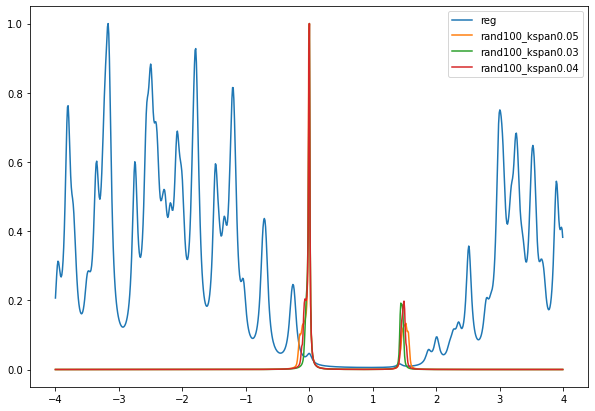

In [87]:
fig, ax = plt.subplots(figsize=(10, 7))
dos.plot(plt,rescale=True)
plt.legend(loc='best')

## Analysis of the JDos

We analyze the JDos assciated to the $v \rightarrow c$ transitions including the 3 valence bands that are quasi degenerate
close to $\Gamma$ in absence of the SOC and the first conduction band. Adding the second conduction band gives rise to
a peak aroung 4.8 eV that is much higher than the pump energy.

In [88]:
r_100_kspan5 = P.PwParser('NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.05.save/data-file-schema.xml')
r_100_kspan3 = P.PwParser('NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.03.save/data-file-schema.xml')
r_100_kspan4 = P.PwParser('NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.04.save/data-file-schema.xml')

Parse file : NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.05.save/data-file-schema.xml
Parse file : NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.03.save/data-file-schema.xml
Parse file : NSCF/bnds_8-kpoints_100-sampling_random_close_Gamma_kspan0.04.save/data-file-schema.xml


In [89]:
weights_100_kspan5 = r_100_kspan5.weights
weights_100_kspan3 = r_100_kspan3.weights
weights_100_kspan4 = r_100_kspan4.weights

In [90]:
transitions_100_kspan5 = r_100_kspan5.get_transitions(set_gap=1.42,initial=[1,2,3],final=[4])
transitions_100_kspan3 = r_100_kspan3.get_transitions(set_gap=1.42,initial=[1,2,3],final=[4])
transitions_100_kspan4 = r_100_kspan4.get_transitions(set_gap=1.42,initial=[1,2,3],final=[4])

Apply a scissor of 0.9546929035002345 eV
Apply a scissor of 0.9546929035002345 eV
Apply a scissor of 0.9546929035002345 eV


In [91]:
jdos = U.Dos()
jdos.append_fromPwData(transitions_100_kspan5,weights_100_kspan5,minVal=0,maxVal=2,eta=4e-3,label='N100_kspan0.05')
jdos.append_fromPwData(transitions_100_kspan3,weights_100_kspan3,minVal=0,maxVal=2,eta=4e-3,label='N100_kspan0.03')
jdos.append_fromPwData(transitions_100_kspan4,weights_100_kspan4,minVal=0,maxVal=2,eta=4e-3,label='N100_kspan0.04')

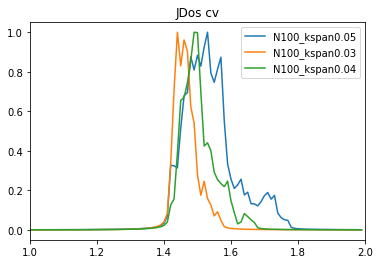

In [92]:
jdos.plot(plt,rescale=True)
plt.title('JDos cv')
plt.xlim(1.,2.)
plt.legend()

We include also the energetic profile of the pump. To do so we consider the analytic form of the QSIN pump and perform its FT

In [93]:
epump = 1.5 # eV
hplanck = U.Planck_ev_ps*1e3 # Planck constant in ev*fs
nupump = epump/hplanck # in fs^-1

width = 30 # fs (it is an estimate since we set 100 fs for the intensity)
t0 = 3*width

T = 2000 # lenght of the time interval
dt = 0.01 # resolution of time sampling
N = int(T/dt) # number of sampled points

time = np.linspace(0,T,N)
field = np.sin(2.*np.pi*nupump*time)*np.exp(-0.5*((time-t0)/width)**2) 

In [94]:
freqs = np.fft.fftfreq(N, d=dt)
fplus = freqs[0:int(N/2)]
fourier = np.fft.fft(field)
fourierplus = fourier[0:int(N/2)]
fabs = np.sqrt(fourierplus.real**2+fourierplus.imag**2)
fabs = fabs/max(fabs)

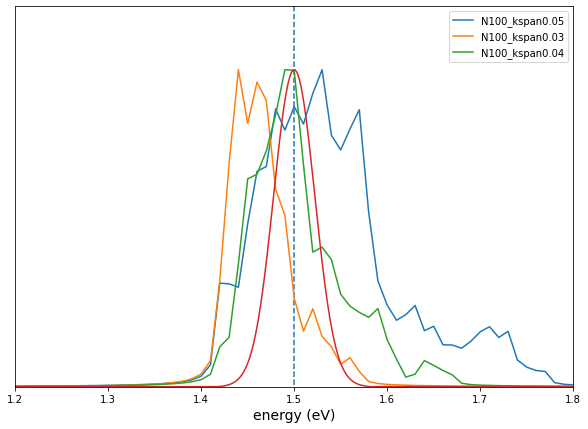

In [95]:
fig, ax = plt.subplots(figsize=(10, 7))

jdos.plot(plt,rescale=True)
plt.plot(hplanck*fplus,fabs)
#plt.title('JDos cv')
plt.vlines(1.5,-2,2,linestyles='--')
plt.yticks([])
plt.xlabel('energy (eV)',size=14)
plt.xlim(1.2,1.8)
plt.ylim(0,1.2)
plt.legend()

It seems that the kspan=0.04 is well fitted with the field profile

## Estimate of the FID time scale

We compute an estimate of the time profile of the signal by computing the weighted average
of a cosine function using the JDOS$_{cv}$ as weight function

In [97]:
from scipy import integrate as I

We use the jdos associated to kspan=0.04 range

Text(0.5, 0, 'time (fs)')

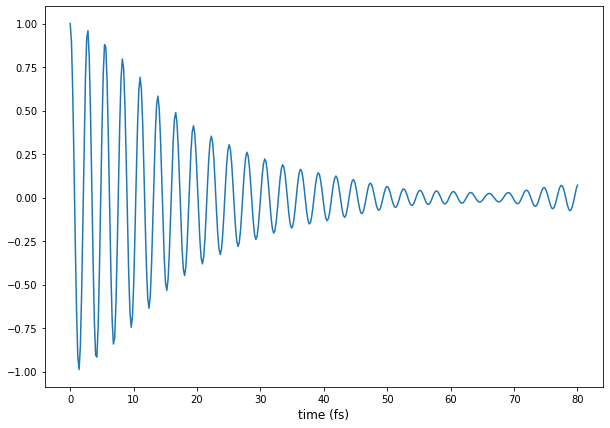

In [98]:
eng = jdos.dos[2][0]
values= jdos.dos[2][1]

norm = I.simps(y=values,x=eng)

nus = eng/(U.Planck_ev_ps*1e3) # in fs^-1
omegas = 2.0*np.pi*nus
tvals = np.linspace(0,80,400) # 400 point for a range of 80 fs

res = []
for t in tvals:
    integrand = values*np.cos(omegas*t)
    res.append(1/norm*I.simps(y=integrand,x=eng))
res100 = np.array(res)

fig, ax = plt.subplots(figsize=(10, 7))
plt.plot(tvals,res)
plt.xlabel('time (fs)',size=12)

comment on the oscillatory behavior?